This tutorial can be downloaded [link](https://github.com/west-code-development/West/raw/master/Doc/tutorials/basic/basic_006.ipynb).

# Intro Tutorial 6: Identification of Localized States

In this tutorial, we show how to identify Kohn-Sham states that are localized in real space. We will identify defect orbitals of the NV$^-$ center in diamond based on the localization factor, defined as

$$
L_n = \int_{V \in \Omega} d^3\mathbf{r} \left| \psi^{\text{KS}}_n(\mathbf{r}) \right|^2
$$

It describes the localization of the n-th KS wavefunction in a given volume $V$ within the supercell volume $\Omega$. The volume $V$ can be a box or a sphere.

More details can be found in [N. Sheng, C. Vorwerk, M. Govoni, and G. Galli, J. Chem. Theory Comput. 18, 3512 (2022)](https://doi.org/10.1021/acs.jctc.2c00240).

## Step 1: Mean-field starting point

As a first step, we perform the mean-field electronic structure calculation within density-functional theory (DFT) using the [Quantum ESPRESSO](https://www.quantum-espresso.org/) code.

Download the following files in your working directory:

In [1]:
%%bash
wget -N -q https://west-code.org/doc/training/nv_diamond_63/pw.in
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/C_ONCV_PBE-1.0.upf
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.0.upf

We can now inspect the `pw.in` file, the input for the `pw.x` code:

In [2]:
%%bash
cat pw.in

&CONTROL
calculation = 'scf'
wf_collect = .true.
pseudo_dir = './'
/
&SYSTEM
input_dft = 'PBE'
ibrav = 0
ecutwfc = 50
nosym = .true.
tot_charge = -1
nspin = 1
nbnd = 176
occupations = 'from_input'
nat = 63
ntyp = 2
/
&ELECTRONS
conv_thr = 1D-08
/
K_POINTS gamma
CELL_PARAMETERS angstrom
7.136012  0.000000  0.000000
0.000000  7.136012  0.000000
0.000000  0.000000  7.136012
ATOMIC_SPECIES
C  12.01099968  C_ONCV_PBE-1.0.upf
N  14.00699997  N_ONCV_PBE-1.0.upf
ATOMIC_POSITIONS crystal
C    0.99996000  0.99996000  0.99996000
C    0.12495000  0.12495000  0.12495000
C    0.99905000  0.25039000  0.25039000
C    0.12350000  0.37499000  0.37499000
C    0.25039000  0.99905000  0.25039000
C    0.37499000  0.12350000  0.37499000
C    0.25039000  0.25039000  0.99905000
C    0.37499000  0.37499000  0.12350000
C    0.00146000  0.00146000  0.50100000
C    0.12510000  0.12510000  0.62503000
C    0.00102000  0.24944000  0.74960000
C    0.12614000  0.37542000  0.87402000
C    0.24944000  0.00102000  0.74960

We can now run `pw.x` on 2 cores.

In [ ]:
%%bash
mpirun -n 2 pw.x -i pw.in > pw.out

We have carried out a spin unpolarized calculation (i.e., `nspin = 1`) because we want to use $L_n$ to define an active space for quantum defect embedding theory (QDET, see [Tutorial 5](https://github.com/west-code-development/West/raw/master/Doc/tutorials/basic/basic_005.ipynb)). The latter uses a spin-unpolarized mean-field starting point to reduce spin contamination in the generation of the parameters for the effective Hamiltonian.

## Step 2.1: Calculation of the localization factor using a box

Localization factors are calculated with the `westpp.x` executable within WEST. You can generate the input file with the following command:

In [3]:
import yaml

d = {}
d['westpp_control'] = {}
d['westpp_control']['westpp_calculation'] = 'L'
d['westpp_control']['westpp_range'] = [1, 176]
d['westpp_control']['westpp_box'] = [6.19, 10.19, 6.28, 10.28, 6.28, 10.28]
        
with open('westpp.in', 'w') as f:
    yaml.dump(d, f, sort_keys=False)

Let us inspect the input file.

In [4]:
%%bash
cat westpp.in

westpp_control:
  westpp_calculation: L
  westpp_range:
  - 1
  - 176
  westpp_box:
  - 6.19
  - 10.19
  - 6.28
  - 10.28
  - 6.28
  - 10.28


The keyword `westpp_calculation: L` triggers the calculation of the localization factor. With `westpp_range`, we can select for which Kohn-Sham states we compute the localization factor. In this tutorial, we use all 176 states. Finally, `westpp_box` specifies the parameter of a box in atomic units to use for the integration. In this case, we have chosen a cubic box around the carbon vacancy at $\left( 8.18, 8.28, 8.28 \right)$ Bohr with an edge of 4 Bohr. The box has a volume of 64 Bohr$^3$, which is smaller than the supercell volume of 2452.24 Bohr$^3$.

Run `westpp.x` on 2 cores.

In [ ]:
%%bash
mpirun -n 2 westpp.x -i westpp.in > westpp.out

`westpp.x` creates a file named `west.westpp.save/westpp.json`. If the reader does NOT have the computational resources to run the calculation, the WEST output file needed for the next step can be directly downloaded as:

In [ ]:
%%bash
mkdir -p west.westpp.save
wget -N -q https://west-code.org/doc/training/nv_diamond_63/westpp.json -O west.westpp.save/westpp.json

We can now visualize the results:

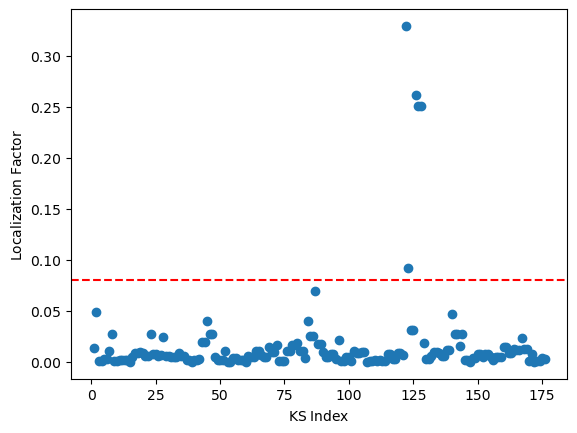

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open('west.westpp.save/westpp.json','r') as f:
    data = json.load(f)

y = np.array(data['output']['L']['K00001']['local_factor'],dtype='f8')
x = np.array([i+1 for i in range(y.shape[0])])

plt.plot(x,y,'o')
plt.axhline(y=0.08,linestyle='--',color='red')

plt.xlabel('KS index')
plt.ylabel('Localization factor')

plt.show()

We see that a number of Kohn-Sham orbitals have a localization factor $>0.08$.

In [6]:
print(x[y>=0.08])

[122 123 126 127 128]


The highest localization factor (`>0.08`) is found for Kohn-Sham orbitals with indices 122, 123, 126, 127, and 128.

## Step 2.2: Calculation of the localization factor using a sphere

Let us modify the input file `westpp.in` to compute localization factors within a sphere.

In [7]:
import yaml

d = {}
d['westpp_control'] = {}
d['westpp_control']['westpp_calculation'] = 'L'
d['westpp_control']['westpp_range'] = [1, 176]
d['westpp_control']['westpp_format'] = 'S'
d['westpp_control']['westpp_r0'] = [8.18, 8.28, 8.28]
d['westpp_control']['westpp_rmax'] = 2.4814
        
with open('westpp.in', 'w') as f:
    yaml.dump(d, f, sort_keys=False)

Let us inspect the input file.

In [8]:
%%bash
cat westpp.in

westpp_control:
  westpp_calculation: L
  westpp_range:
  - 1
  - 176
  westpp_format: S
  westpp_r0:
  - 8.18
  - 8.28
  - 8.28
  westpp_rmax: 2.4814


The keyword `westpp_format: S` instructs the code to compute the localization factor within a sphere, which is centered around $\left( 8.18, 8.28, 8.28 \right)$ Bohr as specified by `westpp_r0` and has a radius of 2.4814 Bohr as specified by `westpp_rmax`. The sphere has a volume of ~64 Bohr$^3$, which is roughly the same as the volume of the box used in the previous section.

Run `westpp.x` on 2 cores.

In [ ]:
%%bash
mpirun -n 2 westpp.x -i westpp.in > westpp.out

`westpp.x` creates a file named `west.westpp.save/westpp.json`. If the reader does NOT have the computational resources to run the calculation, the WEST output file needed for the next step can be directly downloaded as:

In [ ]:
%%bash
mkdir -p west.westpp.save
wget -N -q https://west-code.org/doc/training/nv_diamond_63/westpp_2.json -O west.westpp.save/westpp.json

We can now visualize the results:

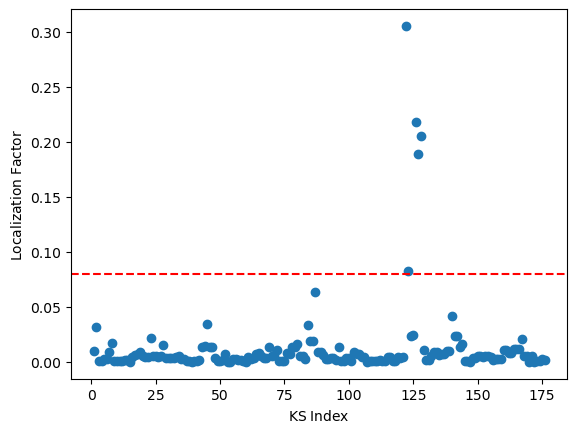

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open('west.westpp.save/westpp.json','r') as f:
    data = json.load(f)

y = np.array(data['output']['L']['K00001']['local_factor'],dtype='f8')
x = np.array([i+1 for i in range(y.shape[0])])

plt.plot(x,y,'o')
plt.axhline(y=0.08,linestyle='--',color='red')

plt.xlabel('KS index')
plt.ylabel('Localization factor')

plt.show()

We see that a number of Kohn-Sham orbitals have a localization factor $>0.08$.

In [10]:
print(x[y>=0.08])

[122 123 126 127 128]


The highest localization factor (`>0.08`) is found for Kohn-Sham orbitals with indices 122, 123, 126, 127, and 128, which are the same orbitals as identified by computing localization factors in a box.